### ANÁLISE E PREVISÃO DA ARRECADAÇÃO FEDERAL

Autor: GABRIEL RODRIGUES  MARCOLINI

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fbprophet import Prophet

#Biblioteca para ignorar os warnings
import warnings
warnings.filterwarnings("ignore")

Importing plotly failed. Interactive plots will not work.


In [2]:
#Define parâmetros iniciais
dataset_path = '.\\dataset\\CSV\\'
filename_input = 'arrecadacao-TOTAL-GERAL-2015-2020.csv'
indicadores = 'xgdvConsulta.csv'

In [3]:
#Faz a leitura dos datasets
#tb = tabela de Arrecadação Federal
#ie = tabela de indicadores econômicos
tb = pd.read_csv(dataset_path+filename_input) 
ie = pd.read_csv(dataset_path+indicadores,sep=';',decimal=',')

In [4]:
#Ajusta o campo DATA do dataframe ie
ie['DATA'] =  pd.to_datetime(ie['DATA'],format="%m/%Y") + pd.tseries.offsets.MonthEnd(0)

In [5]:
#Ajusta o campo DATA do dataframe tb
tb['DATA'] = pd.to_datetime(tb['DATA'],format="%Y/%m/%d")

In [6]:
#Unindo os dataframes tb + ie
left = tb.groupby([tb['DATA']]).sum()
right = ie
result = pd.merge(left,right,how='inner',on='DATA')
result

,DATA,VALOR,IGP-M,IPCA,INPC,SELIC
0,2015-01-31,1.252819e+11,0.76,1.24,1.48,0.94
1,2015-02-28,8.998163e+10,0.27,1.22,1.16,0.82
2,2015-03-31,9.411215e+10,0.98,1.32,1.51,1.04
3,2015-04-30,1.092412e+11,1.17,0.71,0.71,0.95
4,2015-05-31,9.150023e+10,0.41,0.74,0.99,0.99
...,...,...,...,...,...,...
61,2020-02-29,1.164304e+11,-0.04,0.25,0.17,0.29
62,2020-03-31,1.097175e+11,1.24,0.07,0.18,0.34
63,2020-04-30,1.011542e+11,0.80,-0.31,-0.23,0.28
64,2020-05-31,7.741535e+10,0.28,-0.38,-0.25,0.24


In [7]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66 entries, 0 to 65
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATA    66 non-null     datetime64[ns]
 1   VALOR   66 non-null     float64       
 2   IGP-M   66 non-null     float64       
 3   IPCA    66 non-null     float64       
 4   INPC    66 non-null     float64       
 5   SELIC   66 non-null     float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 3.6 KB


In [8]:
# Criando um novo DF para tratar os desvios de arrecadação (outliers) observados em 10/2016 e 04, 05 e 06/2020.
# Os valores serão substitudo pelo valor arrecadado no mesmo mês do ano anterior. 
#outliers = ['2016-10-31','2020-04-30','2020-05-31','2020-06-30']

result_n = result.copy()

result_n.loc[(result_n['DATA'] == '2016-10-31'),'VALOR'] = result_n.loc[(result_n['DATA'] == '2015-10-31'),'VALOR'].values
result_n.loc[(result_n['DATA'] == '2020-04-30'),'VALOR'] = result_n.loc[(result_n['DATA'] == '2019-04-30'),'VALOR'].values
result_n.loc[(result_n['DATA'] == '2020-05-31'),'VALOR'] = result_n.loc[(result_n['DATA'] == '2019-05-31'),'VALOR'].values
result_n.loc[(result_n['DATA'] == '2020-06-30'),'VALOR'] = result_n.loc[(result_n['DATA'] == '2019-06-30'),'VALOR'].values



In [9]:
#Define função para calcular o MAPE - Mean Absolute Percentage Error
def mape(y_pred,y_true):

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [10]:
# Ajustar parâmetros de plotagem
#plt.rcParams.keys()
plt.rcParams["text.color"] = 'Blue'
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["figure.figsize"] = [15, 6]
plt.rcParams["lines.linewidth"] = 2.0

# Modelo Facebook Prophet

In [11]:
# Definindo o dataset a ser analisado
df_real = result.groupby([result['DATA']]).sum()['VALOR']
df_normal = result_n.groupby([result_n['DATA']]).sum()['VALOR']
df = pd.DataFrame(df_normal)

In [12]:
# Ajustando o dataset para uso com o Prophet
df.reset_index(inplace=True)
df.columns=['ds','y']

In [13]:
#Separando em treino e teste
train = df.iloc[:-18]
test = df.iloc[-18:]

In [14]:
# Criando o modelo Prophet e treinando
m = Prophet(daily_seasonality=False, weekly_seasonality=False,
            seasonality_mode='multiplicative')
m.fit(train)
# Fazendo a previsão no tamanho da base de teste
yhat = m.predict(test)

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [15]:
# Criando novos DataFrames com indice = 'ds'
yhat2 =  yhat.set_index('ds')
test2 = test.set_index('ds')

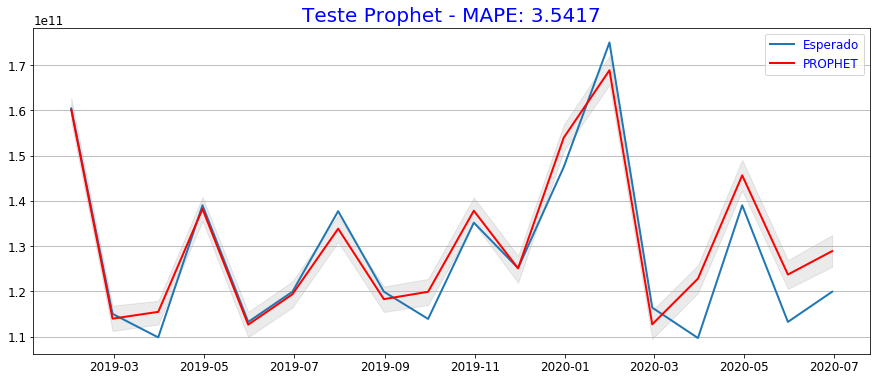

In [16]:
#Plota o resultado do modelo
plt.plot(test2, label='Esperado')
plt.plot(yhat2['yhat'], color='red', label='PROPHET')
plt.fill_between(yhat2.index, yhat['yhat_lower'], yhat['yhat_upper'],
                 color='k', alpha=.08)
plt.title('Teste Prophet - MAPE: %.4f' % mape(yhat2['yhat'],test2['y']))
plt.grid(True,axis='y')
plt.legend(loc='best')

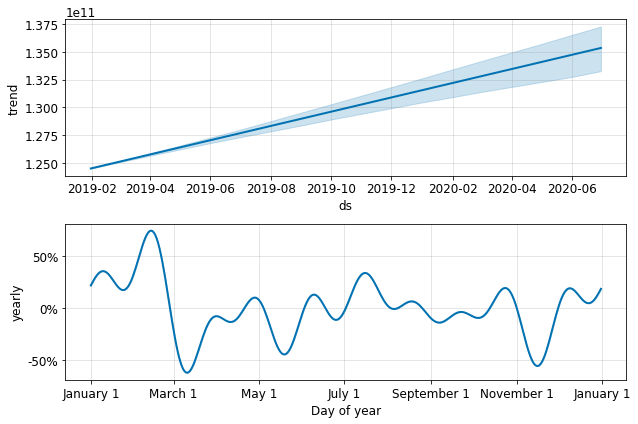

In [17]:
fig2 = m.plot_components(yhat)

## Usando o PROPHET para uma previsão com base nos Valores Normais de arrecadação

In [18]:
df = pd.DataFrame(df_normal)
df.reset_index(inplace=True)
df.columns=['ds','y']

In [19]:
# Criando o modelo Prophet e treinando
m_normal = Prophet(daily_seasonality=False, weekly_seasonality=False,
                   seasonality_mode='multiplicative')
m_normal.fit(df)

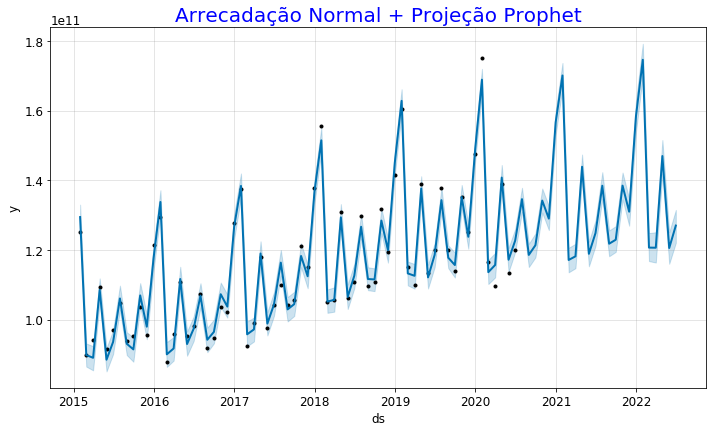

In [20]:
future_n = m_normal.make_future_dataframe(periods=24,freq='M')
fcst_n = m_normal.predict(future_n)
fig_n = m_normal.plot(fcst_n)
plt.title('Arrecadação Normal + Projeção Prophet') 
plt.show()

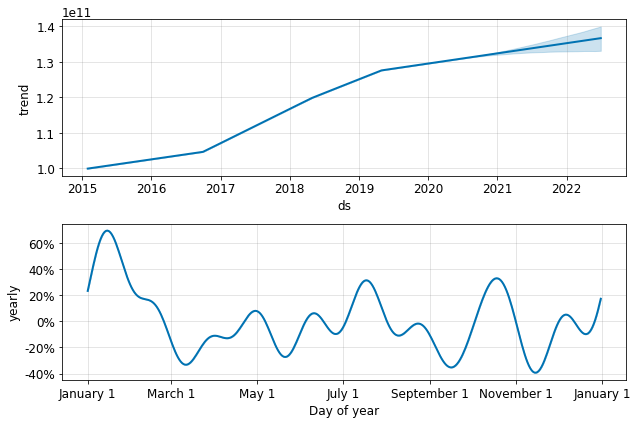

In [21]:
fig2 = m_normal.plot_components(fcst_n)

## Usando o PROPHET para uma previsão com base nos valores reais de arrecadação

In [22]:
df = pd.DataFrame(df_real)
df.reset_index(inplace=True)
df.columns=['ds','y']

In [23]:
# Criando o modelo Prophet e treinando
m_real = Prophet(daily_seasonality=False, weekly_seasonality=False, 
                 seasonality_mode='multiplicative')
m_real.fit(df)

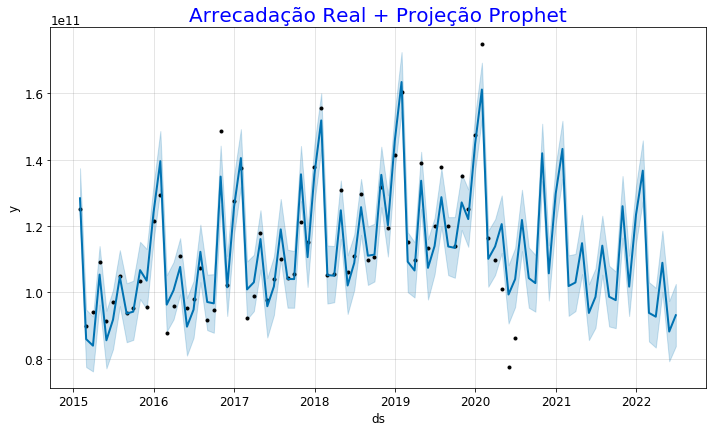

In [24]:
future_r = m_real.make_future_dataframe(periods=24,freq='M')
fcst_r = m_real.predict(future_r)
fig_r = m_real.plot(fcst_r)
plt.title('Arrecadação Real + Projeção Prophet') 
plt.show()

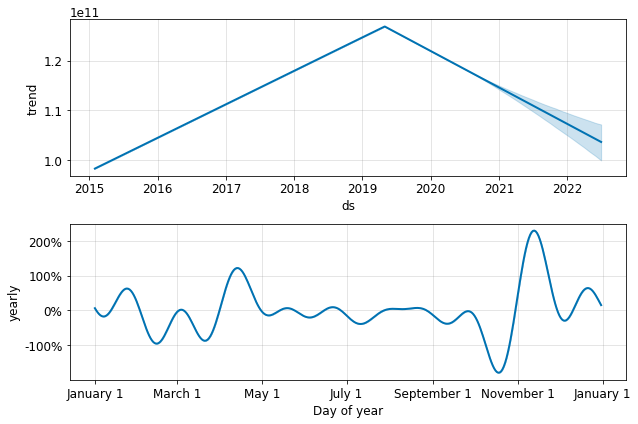

In [25]:
fig2_r = m_real.plot_components(fcst_r)